## Part 1 - Requirements

The city is going to launch a new bike sharing system. Your task is to design a relational database to support its operation. The bike sharing system works as follows:

1. Riders can buy annual, semiannual or monthly membership. We need to have a record of each member's name and address in order to send them a key. Keys can be used to check out bikes at any bike station. Members have the option to renew their memberships before they expire. A member becomes inactive when his or her membership expires, therefore we need to know when their memberships expire. 

1. Each bike station has a pubic name (i.e. "18th & C St NW"). Occasionally in response to public requests, stations can be renamed. Each bike station have been built with a number of docking points.

1. Each bike is either serviceable or disabled. If it is disabled, it is removed from the station for repair.

1. For simplicity's sake, each serviceable bike is either docked at a station or checked out by a member. If it is checked out by a member, the system needs to know who has checked it out and when.

Your database should minimally support the above requirements.

## Part 2 - Designing a Database Schema (35 points)

Based on what you read above, design a relational database schema consisting of *at least* 3 tables. Document your schema with a schema diagram.  There are several tools available for this, such as [Google Drawings](https://docs.google.com/drawings/) and Microsoft Visio. Make sure to include the schema diagram in your submission. Embed and display the diagram in your notebook. **Discuss your major design decisions.** Be aware that your schema is designed to support transaction processing and should be optimized for writes and data consistency.

We are looking for the following when grade this part of the project:

* All required attributes are recorded.
* In the schema diagram, all primary keys are underlined. Directed lines are drawn from the foreign keys to the primary keys.
* Your database schema should be designed to promite data consistency and integrity and reduce the duplication of data. Strive for 3NF.
* Your database schema should be designed to support the requirements described in Part 1, as well as problems in Part 4 and 5.
* Key design decisions are discussed and documented in Markdown cells.

See slide 23 of week-04 lecture for an example of schema diagram. 

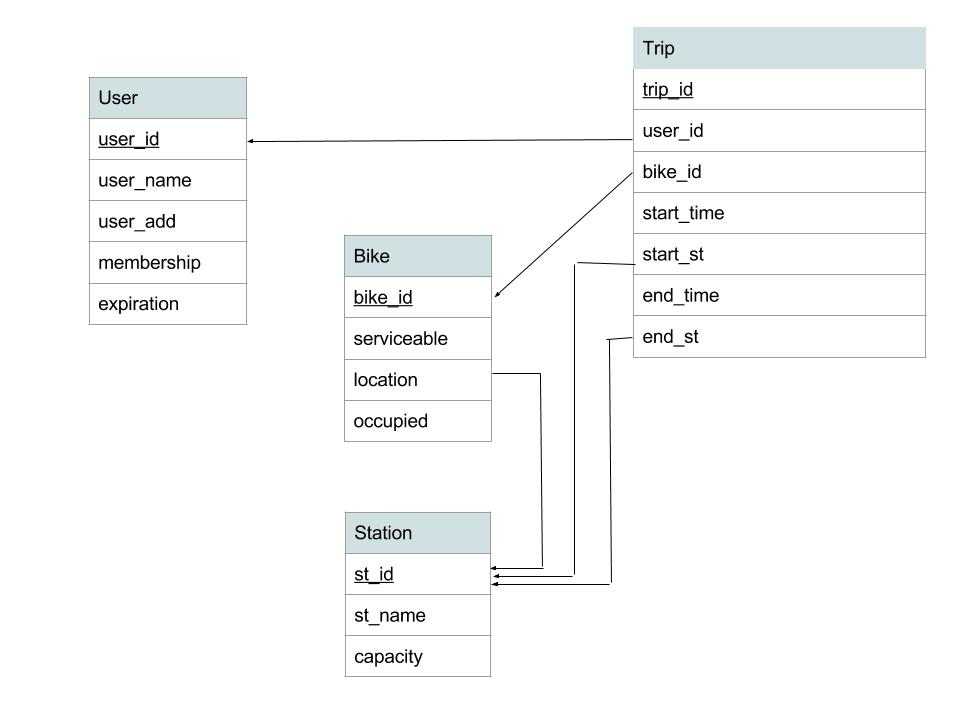

In [3]:
from IPython.display import Image
Image("/home/ubuntu/Data Management Proj 2.jpg")

## Part 3 - ETL (30 points)
Please use markdown cells to **document major steps**. Use SQL queries and markdown cells to demonstrate that records are created or updated successfully.

### Problem 3.1
Examine the data located at https://s3.amazonaws.com/dmfa-2017/bike_stations.csv.
Create and connect to a new PostgreSQL database named `proj2`. Use SQL DDL to create your tables in it based on the database schema you designed in Part 2 and the data. Don't forget about the contraints (primary keys, foreign keys, proper attribute types, NOT NULL etc).

First, drop the database named `proj2` if it exists. It is necessary so that we can run this notebook repeatedly. If you get the error that says "database proj2 does not exist", that is fine. However if it complains that "There is 1 other session using the database", please restart the Kernel and try it again.

In [2]:
!dropdb -U student proj2

In [4]:
!createdb -U student proj2

createdb: database creation failed: ERROR:  database "proj2" already exists


### Problem 3.2
Use the data located at https://s3.amazonaws.com/dmfa-2017/bike_stations.csv to populate your database. You may import the CSV file content into a temporary table in your database `proj2`. Just remember to remove it after you are done. 

Since the data doesn't include information about members, you will need to make up a few (4 or 5) members in your database. Some of their memberships have expired.

In [5]:
%load_ext sql
%sql postgresql://student@/proj2
!wget https://s3.amazonaws.com/dmfa-2017/bike_stations.csv

--2017-10-12 22:45:03--  https://s3.amazonaws.com/dmfa-2017/bike_stations.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.97.37
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.97.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169879 (166K) [text/csv]
Saving to: ‘bike_stations.csv.2’

bike_stations.csv.2 100%[===================>] 165.90K  --.-KB/s    in 0.005s  

2017-10-12 22:45:03 (34.3 MB/s) - ‘bike_stations.csv.2’ saved [169879/169879]



In [6]:
!head bike_stations.csv | csvlook

|--------------+------------------+----------------+----------------------------------------------+-------------------|
|  Bike number | Bike serviceable | Station number | Station name                                 | Station capacity  |
|--------------+------------------+----------------+----------------------------------------------+-------------------|
|  W00005      | t                | 32011          | Maple & Ritchie Ave                          | 28                |
|  W00174      | t                | 31246          | M St & Pennsylvania Ave NW                   | 10                |
|  W00196      | t                | 31408          | Takoma Metro                                 | 12                |
|  W00216      | t                | 31309          | Fessenden St & Wisconsin Ave NW              | 8                 |
|  W00267      | t                | 31125          | 15th & W St NW                               | 24                |
|  W00310      | t                | 3105

In [7]:
%%sql
DROP TABLE IF EXISTS origin;

CREATE TABLE origin(
    bike_id TEXT, 
    serviceable TEXT, 
    st_id INTEGER,
    st_name TEXT,
    capacity INTEGER);

Done.
Done.


[]

In [8]:
!pwd

/home/ubuntu


In [9]:
%%sql
COPY origin FROM '/home/ubuntu/bike_stations.csv'
CSV
HEADER;

4317 rows affected.


[]

In [10]:
%%sql
DROP TABLE IF EXISTS Member;

CREATE TABLE Member(
    user_id TEXT PRIMARY KEY, 
    user_name TEXT NOT NULL, 
    user_add TEXT NOT NULL,
    membership TEXT NOT NULL,
    expiration TEXT NOT NULL);

DROP TABLE IF EXISTS Station;

CREATE TABLE Station(
    st_id INTEGER PRIMARY KEY, 
    st_name TEXT NOT NULL, 
    capacity INTEGER NOT NULL);


Done.
Done.
Done.
Done.


[]

In [11]:
%%sql
DROP TABLE IF EXISTS Bike;

CREATE TABLE Bike(
    bike_id TEXT PRIMARY KEY, 
    serviceable TEXT NOT NULL, 
    location INTEGER REFERENCES Station, 
    occupied INTEGER NOT NULL);

DROP TABLE IF EXISTS Trip;

CREATE TABLE Trip(
    trip_id TEXT PRIMARY KEY, 
    user_id TEXT NOT NULL REFERENCES Member, 
    bike_id TEXT NOT NULL REFERENCES Bike,
    start_time TEXT NOT NULL,
    start_st INTEGER NOT NULL REFERENCES Station,
    end_time TEXT,
    end_st INTEGER REFERENCES Station);

Done.
Done.
Done.
Done.


[]

In [12]:
%%sql
INSERT INTO Member values ('10001', 'Ann A', '1 E St NW, Washington', 'annual', '2017-10-02');
INSERT INTO Member values ('10002', 'Ben B', '2 E St NW, Washington', 'semiannual', '2018-10-01');
INSERT INTO Member values ('10003', 'Cath C', '3 E St NW, Washington', 'monthly', '2017-12-01');
INSERT INTO Member values ('10004', 'Dan D', '4 E St NW, Washington', 'monthly', '2018-06-30');


1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.


[]

In [13]:
%%sql
INSERT INTO Station
    SELECT DISTINCT st_id, st_name, capacity FROM origin
    WHERE st_id IS NOT NULL;

452 rows affected.


[]

In [14]:
%%sql
INSERT INTO Bike 
    SELECT bike_id, serviceable, st_id, 0 FROM origin
    WHERE bike_id IS NOT NULL;

4298 rows affected.


[]

In [15]:
%%sql
UPDATE Bike
SET occupied = 1 WHERE location IS NULL;

475 rows affected.


[]

In [16]:
%sql DROP TABLE origin;

Done.


[]

In [17]:
%sql SELECT * FROM Bike WHERE serviceable = 'f';

475 rows affected.


bike_id,serviceable,location,occupied
W00178,f,None,1
W20763,f,None,1
W22526,f,None,1
W23079,f,None,1
W00317,f,None,1
W22510,f,None,1
W21640,f,None,1
W00571,f,None,1
W22899,f,None,1
W23136,f,None,1


In [18]:
%sql SELECT * FROM Station LIMIT 10;

10 rows affected.


st_id,st_name,capacity
31221,18th & M St NW,13
31287,10th St & L'Enfant Plaza SW,8
31507,1st & Washington Hospital Center NW,8
31119,14th & Belmont St NW,14
32010,Philadelphia & Maple Ave,28
31501,12th & Newton St NE,5
31313,Connecticut Ave & Tilden St NW,8
32034,Ripley & Bonifant St,8
31603,1st & M St NE,17
31909,Mount Vernon Ave & Four Mile Run Park,13


## Part 4 - Operations (15 points)
Use SQL queries and markdown cells to demonstrate that records are created or updated successfully.

### Problem 4.1
The bike 'W20131' is having mechanical problems and needs to be repaired off-site. Use SQL UPDATE statements to record the fact that this bike is no longer serviceable and has been removed from the station where it was docked at.

In [19]:
%%sql
UPDATE Bike
SET serviceable = 'f', location = NULL, occupied = 1
WHERE bike_id = 'W20131';

1 rows affected.


[]

In [20]:
%sql SELECT * FROM Bike WHERE bike_id = 'W20131';

1 rows affected.


bike_id,serviceable,location,occupied
W20131,f,None,1


### Problem 4.2
The bike station at Adams Mill & Columbia Rd NW has been expanded. Use SQL UPDATE statements to change the name of the bike station from "Adams Mill & Columbia Rd NW" to "18th & Columbia Rd NW" and increase its capacity by 10.

In [21]:
%%sql
UPDATE Station
SET st_name = '18th & Columbia Rd NW', capacity = 10
WHERE st_id = (SELECT st_id FROM Station WHERE st_name = 'Adams Mill & Columbia Rd NW');

1 rows affected.


[]

In [22]:
%sql SELECT * FROM Station WHERE st_name LIKE '18th%';

9 rows affected.


st_id,st_name,capacity
31221,18th & M St NW,13
31114,18th St & Wyoming Ave NW,17
31242,18th St & Pennsylvania Ave NW,5
31521,18th & Monroe St NE,17
31284,18th & C St NW,10
31510,18th St & Rhode Island Ave NE,7
31278,18th & R St NW,11
31001,18th & Eads St.,7
31104,18th & Columbia Rd NW,10


### Problem 4.3
Use SQL UPDATE and/or INSERT statements to record the transaction that an active member checked out the bike 'W00005' from station 'Maple & Ritchie Ave' at '2017-10-01 08:46:00'.

In [23]:
%%sql
INSERT INTO Trip values ('T10001', '10001', 'W00005', '2017-10-01 08:46:00', 
                          (SELECT st_id FROM Station WHERE st_name = 'Maple & Ritchie Ave'));
UPDATE Bike 
SET location = NULL, occupied = 1
WHERE bike_id = 'W00005';

1 rows affected.
1 rows affected.


[]

In [24]:
%sql SELECT * FROM Trip;

1 rows affected.


trip_id,user_id,bike_id,start_time,start_st,end_time,end_st
T10001,10001,W00005,2017-10-01 08:46:00,32011,None,None


In [25]:
%sql SELECT * FROM Bike WHERE bike_id = 'W00005';

1 rows affected.


bike_id,serviceable,location,occupied
W00005,t,None,1


When a bike is checked out, a "Trip" entry is inserted with end_time and end_st being null, and "Bike" status is updated. When this bike is checked back in, update end_time and end_st to the previous "Trip" entry, and update "Bike" status.

## Part 5 - Queries (20 points)

Use SQL SELECT statements to answer the following questions. Use markdown cells to explain your SQL statements and results if needed.

### Problem 5.1
For all members, display their name, membership type (annual, semiannual or monthly, in readable text), membership status (active or expired, boolean value is fine) and the date when the membership expires.

In [26]:
%%sql
SELECT user_name, membership,(DATE(expiration) > DATE(CURRENT_DATE)) AS Active, expiration
FROM Member;

4 rows affected.


user_name,membership,active,expiration
Ann A,annual,False,2017-10-02
Ben B,semiannual,True,2018-10-01
Cath C,monthly,True,2017-12-01
Dan D,monthly,True,2018-06-30


## Select user_name, membership and expiration date. Judge whether it expires by comparing the date that day with the expiration date.

### Problem 5.2
Display the first 10 bikes base on the bike number in ascending order. For each bike, list its status (serviceable or disabled, boolean value is fine), the station name where it is docked at if there is any, the member if the bike is currently checked out, and when it was checked out. Hint: you should see one disabled bike and one checked out bike.

In [27]:
%%sql
SELECT Bike.bike_id, Bike.serviceable, Station.st_name, user_name, start_time
FROM Bike
LEFT OUTER JOIN Station
ON Bike.location = Station.st_id
LEFT OUTER JOIN Trip
ON Trip.bike_id = Bike.bike_id
FULL OUTER JOIN Member
ON Trip.user_id = Member.user_id
ORDER BY bike_id ASC
LIMIT 10;

10 rows affected.


bike_id,serviceable,st_name,user_name,start_time
W00001,t,Ward Circle / American University,None,None
W00005,t,None,Ann A,2017-10-01 08:46:00
W00007,t,Gallaudet / 8th St & Florida Ave NE,None,None
W00009,t,Mount Vernon Ave & Bruce St,None,None
W00010,t,Jefferson Memorial,None,None
W00011,f,None,None,None
W00012,t,Wilson Blvd & N Illinois St,None,None
W00013,t,Lee Center,None,None
W00014,t,Wilson Blvd & N Illinois St,None,None
W00015,t,Saint Asaph St & Pendleton St,None,None


## Select bike_id, serviceable, station name and start time. Join the information together and include null by "LEFT JOIN".

### Problem 5.3
Display the top 10 stations which currently have the most bikes docked. For each station, list the station name and the total number of bikes docked there.

In [28]:
%%sql
SELECT Station.st_name, count(*) AS bike_docked
FROM Bike
JOIN Station
    ON Bike.location = Station.st_id
AND Bike.occupied = 0
GROUP BY st_name
ORDER BY bike_docked DESC
LIMIT 10;

10 rows affected.


st_name,bike_docked
Columbus Circle / Union Station,49
14th & V St NW,41
2nd & G St NE,36
13th & D St NE,33
12th & U St NW,32
11th & Kenyon St NW,29
1st & N St SE,28
13th & H St NE,27
6th & H St NE,27
4th & M St SW,27


## After selecting station name, it is time to calculate the bike docked in the station, which means the bikes not occupied. Hence, do the calculation by counting the number of bike unoccupied.

### Problem 5.4
Display the first 10 stations based on their names in ascending order. For each station, list station name and the number of available docking points accepting bike returns. Verify the numbers are correct.

In [29]:
%%sql
SELECT Station.st_name, (capacity - 
    (SELECT count(*)
    FROM Bike
    WHERE Bike.occupied = 0
    AND Bike.location = Station.st_id)) AS vancancy
FROM Station
ORDER BY st_name
LIMIT 10;

10 rows affected.


st_name,vancancy
10th & E St NW,2
10th & Florida Ave NW,5
10th & G St NW,8
10th & K St NW,6
10th & Monroe St NE,2
10th St & Constitution Ave NW,5
10th St & L'Enfant Plaza SW,7
10th & U St NW,2
11th & F St NW,2
11th & H St NE,3


## The number of vancancy is exactly the difference between the capacity of a station and the bikes docked in that station. Hence, do minus is the way to solve the problem.